# Integrated Gradients Explainability in Turkish Text Classification

## Imports and Parameters

In [1]:
%load_ext autoreload
%autoreload 2

from itables import init_notebook_mode
init_notebook_mode(all_interactive=False)
from itables import show
import itables.options as opt
opt.style = "table-layout:auto; width:50%; margin-right:auto; margin-left:0;"
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 100)
# pd.reset_option('display.max_colwidth')
import pickle
from tqdm.notebook import tqdm

from captum.attr import LayerIntegratedGradients
from captum.attr import visualization as viz

import torch
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

import sys
sys.path.append("Helper_Functions/") 
from general_utils import *
from ig_utils import *

<IPython.core.display.Javascript object>

In [2]:
path_config = "Config/config.json"
config = load_hyperparameters(path_config)

path_ttc4900 = config["path_ttc4900"]
path_tr_news = config["path_tr_news"]
path_interpress = config["path_interpress"]
path_tc32 = config["path_tc32"]

path_bert_model_ttc4900 = config["path_bert_model_ttc4900"]
path_bert_model_tr_news = config["path_bert_model_tr_news"] 
path_bert_model_interpress = config["path_bert_model_interpress"]
path_bert_model_tc32 = config["path_bert_model_tc32"]

path_tbt_model_ttc4900 = config["path_tbt_model_ttc4900"]
path_tbt_model_tr_news = config["path_tbt_model_tr_news"] 
path_tbt_model_interpress = config["path_tbt_model_interpress"]
path_tbt_model_tc32 = config["path_tbt_model_tc32"]

path_ig = config["path_ig"]
thresholds = config["thresholds"]
only_load = config["only_load"]

pipeline_parameters = config["pipeline_parameters"]
device = torch.device(config["device"]) if torch.cuda.is_available() else torch.device("cpu")

display(pd.DataFrame(list(config.items()), columns=['Parameter', 'Value']))

,Parameter,Value
0,path_ttc4900,Data/TTC_4900/
1,path_tr_news,Data/TR_News/
2,path_interpress,Data/Interpress/
3,path_tc32,Data/TC32/
4,path_bert_model_ttc4900,Models/bertturk_text_classification_fine_tuned_ttc4900
5,path_bert_model_tr_news,Models/bertturk_text_classification_fine_tuned_tr_news
6,path_bert_model_interpress,Models/bertturk_text_classification_fine_tuned_interpress
7,path_bert_model_tc32,Models/bertturk_text_classification_fine_tuned_tc32
8,path_tbt_model_ttc4900,Models/turkishbertweet_text_classification_fine_tuned_ttc4900
9,path_tbt_model_tr_news,Models/turkishbertweet_text_classification_fine_tuned_tr_news


## Load Models

In [3]:
from load_models import prepare_models

# Load BERTTurk models

bert_model_ttc4900, \
bert_tokenizer_ttc4900, \
bert_config_ttc4900, \
bert_pipeline_text_ttc4900, \
bert_label2id_ttc4900, \
bert_id2label_ttc4900 = prepare_models(path_bert_model_ttc4900, device)

bert_model_tr_news, \
bert_tokenizer_tr_news, \
bert_config_tr_news, \
bert_pipeline_text_tr_news, \
bert_label2id_tr_news, \
bert_id2label_tr_news = prepare_models(path_bert_model_tr_news, device)

bert_model_interpress, \
bert_tokenizer_interpress, \
bert_config_interpress, \
bert_pipeline_text_interpress, \
bert_label2id_interpress, \
bert_id2label_interpress = prepare_models(path_bert_model_interpress, device)

bert_model_tc32, \
bert_tokenizer_tc32, \
bert_config_tc32, \
bert_pipeline_text_tc32, \
bert_label2id_tc32, \
bert_id2label_tc32 = prepare_models(path_bert_model_tc32, device)

# Load TurkishBERTweet models

tbt_model_ttc4900, \
tbt_tokenizer_ttc4900, \
tbt_config_ttc4900, \
tbt_pipeline_text_ttc4900, \
tbt_label2id_ttc4900, \
tbt_id2label_ttc4900 = prepare_models(path_tbt_model_ttc4900, device)

tbt_model_tr_news, \
tbt_tokenizer_tr_news, \
tbt_config_tr_news, \
tbt_pipeline_text_tr_news, \
tbt_label2id_tr_news, \
tbt_id2label_tr_news = prepare_models(path_tbt_model_tr_news, device)

tbt_model_interpress, \
tbt_tokenizer_interpress, \
tbt_config_interpress, \
tbt_pipeline_text_interpress, \
tbt_label2id_interpress, \
tbt_id2label_interpress = prepare_models(path_tbt_model_interpress, device)

tbt_model_tc32, \
tbt_tokenizer_tc32, \
tbt_config_tc32, \
tbt_pipeline_text_tc32, \
tbt_label2id_tc32, \
tbt_id2label_tc32 = prepare_models(path_tbt_model_tc32, device)

Error caught was: No module named 'triton'



'bertturk_text_classification_fine_tuned_ttc4900' is loaded.

'bertturk_text_classification_fine_tuned_tr_news' is loaded.

'bertturk_text_classification_fine_tuned_interpress' is loaded.

'bertturk_text_classification_fine_tuned_tc32' is loaded.

'turkishbertweet_text_classification_fine_tuned_ttc4900' is loaded.

'turkishbertweet_text_classification_fine_tuned_tr_news' is loaded.

'turkishbertweet_text_classification_fine_tuned_interpress' is loaded.

'turkishbertweet_text_classification_fine_tuned_tc32' is loaded.


## Load Datasets

In [7]:
from load_datasets import prepare_datasets

ttc4900_test, tr_news_test, interpress_test, tc32_test = prepare_datasets(path_ttc4900, path_tr_news, path_interpress, path_tc32)

print("TTC 4900 Test Set:\n\n", ttc4900_test)
print("\nTR News Test Set:\n\n", tr_news_test)
print("\nInterpress Test Set:\n\n", interpress_test)
print("\nTC 32 Test Set:\n\n", tc32_test)

TTC 4900 Test Set:

 Dataset({
    features: ['text', 'label'],
    num_rows: 735
})

TR News Test Set:

 Dataset({
    features: ['text', 'label'],
    num_rows: 880
})

Interpress Test Set:

 Dataset({
    features: ['text', 'label'],
    num_rows: 1000
})

TC 32 Test Set:

 Dataset({
    features: ['text', 'label'],
    num_rows: 9600
})


## Inference on Full Text

### BERTTurk

In [8]:
path_classification_results = "Data/Classification_Results/BERTTurk/"

with open(path_classification_results + 'bert_full_text_preds_ttc4900.pkl', 'rb') as file:
    bert_full_text_preds_ttc4900 = pickle.load(file)

with open(path_classification_results + 'bert_full_text_preds_tr_news.pkl', 'rb') as file:
    bert_full_text_preds_tr_news = pickle.load(file)

with open(path_classification_results + 'bert_full_text_preds_interpress.pkl', 'rb') as file:
    bert_full_text_preds_interpress = pickle.load(file)

with open(path_classification_results + 'bert_full_text_preds_tc32.pkl', 'rb') as file:
    bert_full_text_preds_tc32 = pickle.load(file)

### TurkishBERTweet

In [9]:
path_classification_results = "Data/Classification_Results/TurkishBERTweet/"

with open(path_classification_results + 'tbt_full_text_preds_ttc4900.pkl', 'rb') as file:
    tbt_full_text_preds_ttc4900 = pickle.load(file)

with open(path_classification_results + 'tbt_full_text_preds_tr_news.pkl', 'rb') as file:
    tbt_full_text_preds_tr_news = pickle.load(file)

with open(path_classification_results + 'tbt_full_text_preds_interpress.pkl', 'rb') as file:
    tbt_full_text_preds_interpress = pickle.load(file)

with open(path_classification_results + 'tbt_full_text_preds_tc32.pkl', 'rb') as file:
    tbt_full_text_preds_tc32 = pickle.load(file)

## Integrated Gradients Explainability

In [10]:
all_exp_results = pd.DataFrame(columns=["ECS", "ORC (+)", "ORC (-)"])

In [11]:
num_samples = 50

ttc4900_test = ttc4900_test.select(range(num_samples))
tr_news_test = tr_news_test.select(range(num_samples))
interpress_test = interpress_test.select(range(num_samples))
tc32_test = tc32_test.select(range(num_samples))

# bert_full_text_preds_ttc4900 = bert_full_text_preds_ttc4900[:num_samples]
# bert_full_text_preds_tr_news = bert_full_text_preds_tr_news[:num_samples]
# bert_full_text_preds_interpress = bert_full_text_preds_interpress[:num_samples]
# bert_full_text_preds_tc32 = bert_full_text_preds_tc32[:num_samples]

tbt_full_text_preds_ttc4900 = tbt_full_text_preds_ttc4900[:num_samples]
tbt_full_text_preds_tr_news = tbt_full_text_preds_tr_news[:num_samples]
tbt_full_text_preds_interpress = tbt_full_text_preds_interpress[:num_samples]
tbt_full_text_preds_tc32 = tbt_full_text_preds_tc32[:num_samples]

### BERTTurk

#### TTC4900

In [12]:
model_ttc4900_output = create_model_output_function(bert_model_ttc4900)
lig_ttc4900 = LayerIntegratedGradients(model_ttc4900_output, bert_model_ttc4900.bert.embeddings)

ttc4900_bert_results = {}

for threshold in thresholds:
    
    ig_values_ttc, score_vis_ttc = apply_ig(path_ig, 
                                            ttc4900_test, 
                                            lig_ttc4900, 
                                            bert_model_ttc4900, bert_tokenizer_ttc4900, 
                                            f"ig_and_scores_ttc_{threshold}_bert",
                                            device,
                                            only_load=only_load)
    
    top_tokens_ttc4900 = apply_thresholding(ig_values_ttc, bert_tokenizer_ttc4900, threshold)
    
    ig_values_ttc_short, score_vis_ttc_short = apply_ig(path_ig, 
                                                        top_tokens_ttc4900, 
                                                        lig_ttc4900,
                                                        bert_model_ttc4900, bert_tokenizer_ttc4900, 
                                                        f"ig_and_scores_ttc_short_{threshold}_bert", 
                                                        device,
                                                        only_load=only_load)
    
    ttc4900_bert_result = compare_probs(ttc4900_test,
                                        bert_full_text_preds_ttc4900,
                                        top_tokens_ttc4900,
                                        1,
                                        bert_model_ttc4900, bert_tokenizer_ttc4900,
                                        bert_pipeline_text_ttc4900,
                                        pipeline_parameters,
                                        device, 
                                        bert_id2label_ttc4900)

    ttc4900_bert_results[threshold] = (score_vis_ttc, score_vis_ttc_short, ttc4900_bert_result)
    
    clear_gpu_memory()
    
    show(ttc4900_bert_results[threshold][2], lengthMenu=list(range(10, 200, 30)), dom="lti")

'ig_and_scores_ttc_0.5_bert' file length: 50
'ig_and_scores_ttc_short_0.5_bert' file length: 50


'ig_and_scores_ttc_0.6_bert' file length: 50
'ig_and_scores_ttc_short_0.6_bert' file length: 50


'ig_and_scores_ttc_0.7_bert' file length: 50
'ig_and_scores_ttc_short_0.7_bert' file length: 50


In [13]:
sample_no = 28

viz.visualize_text([ttc4900_bert_results[0.6][0][sample_no]])
viz.visualize_text([ttc4900_bert_results[0.6][1][sample_no]])
display()


Explanations Contribution Score (ECS)          :  0.974
Overall Relative Change (ORC) positive changes :  3.888 %
Overall Relative Change (ORC) negative changes : -2.106 %


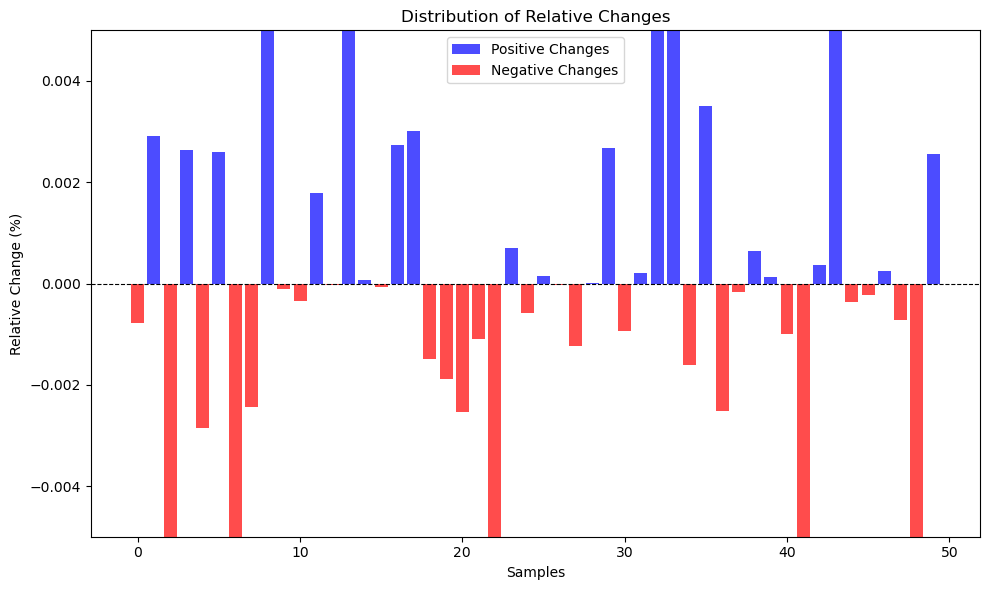


Explanations Contribution Score (ECS)          :  0.976
Overall Relative Change (ORC) positive changes :  3.747 %
Overall Relative Change (ORC) negative changes : -1.809 %


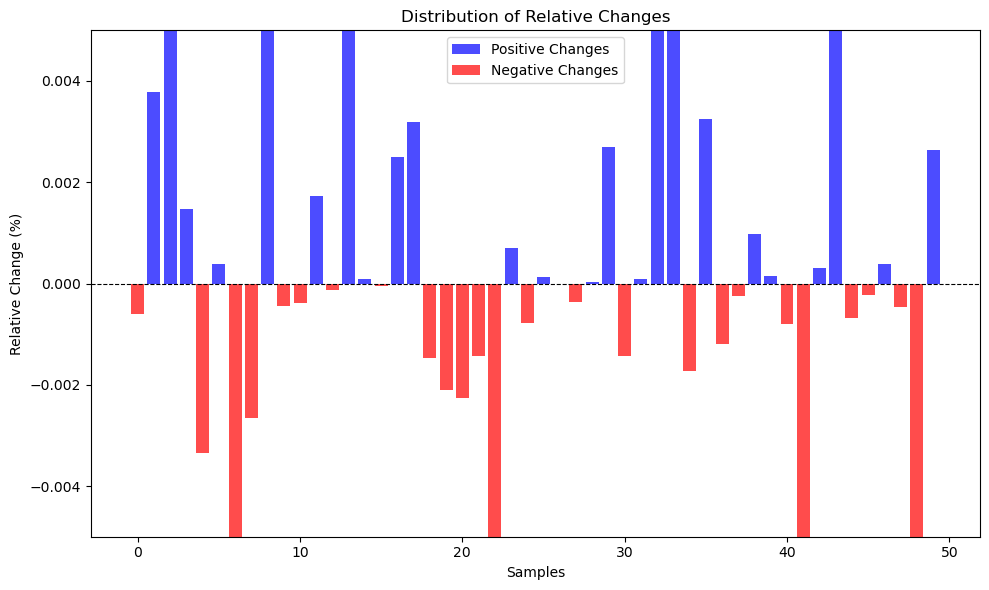


Explanations Contribution Score (ECS)          :  0.974
Overall Relative Change (ORC) positive changes :  4.243 %
Overall Relative Change (ORC) negative changes : -1.991 %


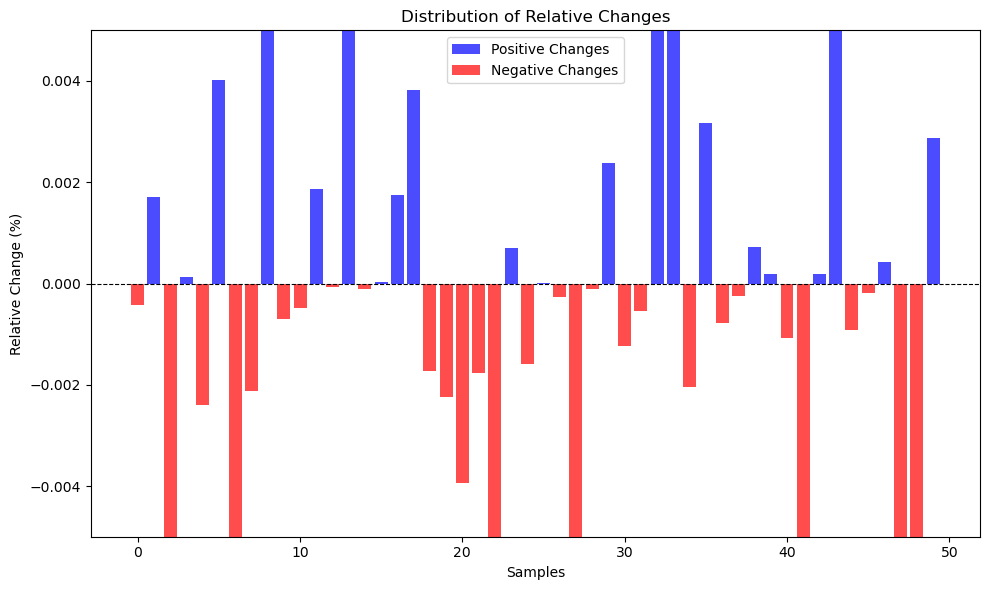

In [14]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_bert_results[0.5][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_bert_results[0.6][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_bert_results[0.7][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### TR News

In [15]:
model_tr_news_output = create_model_output_function(bert_model_tr_news)
lig_tr_news = LayerIntegratedGradients(model_tr_news_output, bert_model_tr_news.bert.embeddings)

tr_news_bert_results = {}

for threshold in thresholds:

    ig_values_tr_news, score_vis_tr_news = apply_ig(path_ig, 
                                                    tr_news_test, 
                                                    lig_tr_news, 
                                                    bert_model_tr_news, bert_tokenizer_tr_news, 
                                                    f"ig_and_scores_tr_news_{threshold}_bert",
                                                    device, 
                                                    only_load=only_load)
    
    top_tokens_tr_news = apply_thresholding(ig_values_tr_news, bert_tokenizer_tr_news, threshold)
    
    ig_values_tr_news_short, score_vis_tr_news_short = apply_ig(path_ig, 
                                                                top_tokens_tr_news, 
                                                                lig_tr_news,
                                                                bert_model_tr_news, bert_tokenizer_tr_news,
                                                                f"ig_and_scores_tr_news_short_{threshold}_bert", 
                                                                device,
                                                                only_load=only_load)
    
    tr_news_bert_result = compare_probs(tr_news_test,
                                        bert_full_text_preds_tr_news,
                                        top_tokens_tr_news,
                                        1,
                                        bert_model_tr_news, bert_tokenizer_tr_news,
                                        bert_pipeline_text_tr_news,
                                        pipeline_parameters,
                                        device, 
                                        bert_id2label_tr_news)

    tr_news_bert_results[threshold] = (score_vis_tr_news, score_vis_tr_news_short, tr_news_bert_result)
    
    clear_gpu_memory()
    
    show(tr_news_bert_results[threshold][2], lengthMenu=list(range(10, 200, 30)), dom="lti")

'ig_and_scores_tr_news_0.5_bert' file length: 50
'ig_and_scores_tr_news_short_0.5_bert' file length: 50


'ig_and_scores_tr_news_0.6_bert' file length: 50
'ig_and_scores_tr_news_short_0.6_bert' file length: 50


'ig_and_scores_tr_news_0.7_bert' file length: 50
'ig_and_scores_tr_news_short_0.7_bert' file length: 50


In [16]:
sample_no = 33

viz.visualize_text([tr_news_bert_results[0.6][0][sample_no]])
viz.visualize_text([tr_news_bert_results[0.6][1][sample_no]])
display()


Explanations Contribution Score (ECS)          :  0.833
Overall Relative Change (ORC) positive changes :  16.859 %
Overall Relative Change (ORC) negative changes : -17.882 %


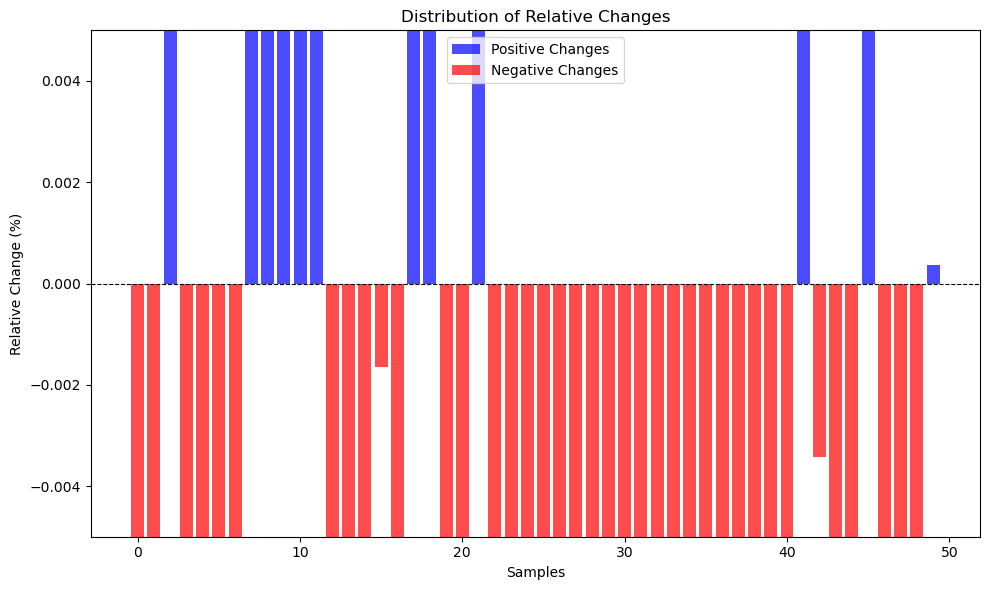


Explanations Contribution Score (ECS)          :  0.834
Overall Relative Change (ORC) positive changes :  16.683 %
Overall Relative Change (ORC) negative changes : -17.712 %


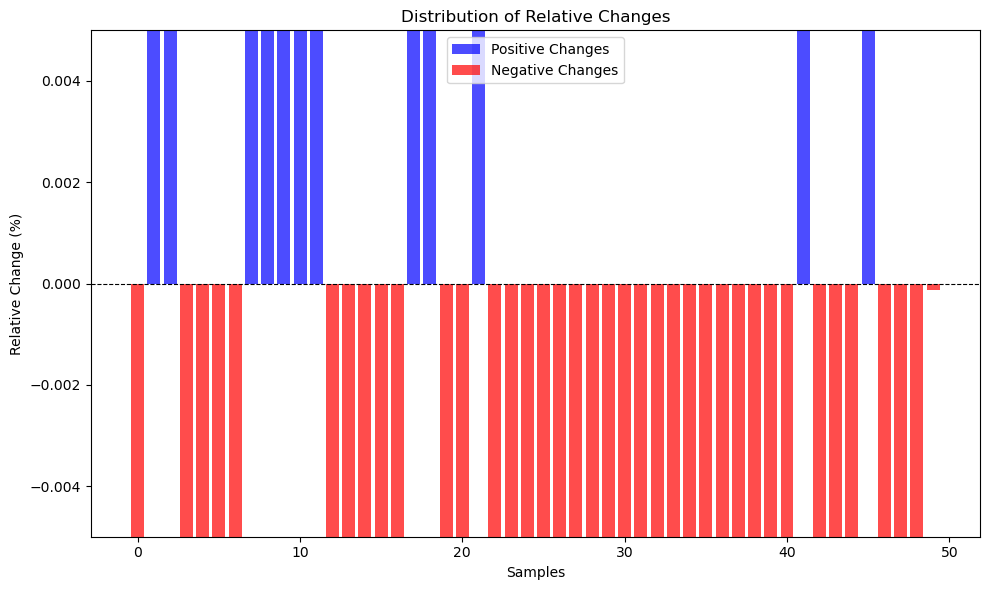


Explanations Contribution Score (ECS)          :  0.838
Overall Relative Change (ORC) positive changes :  15.697 %
Overall Relative Change (ORC) negative changes : -17.806 %


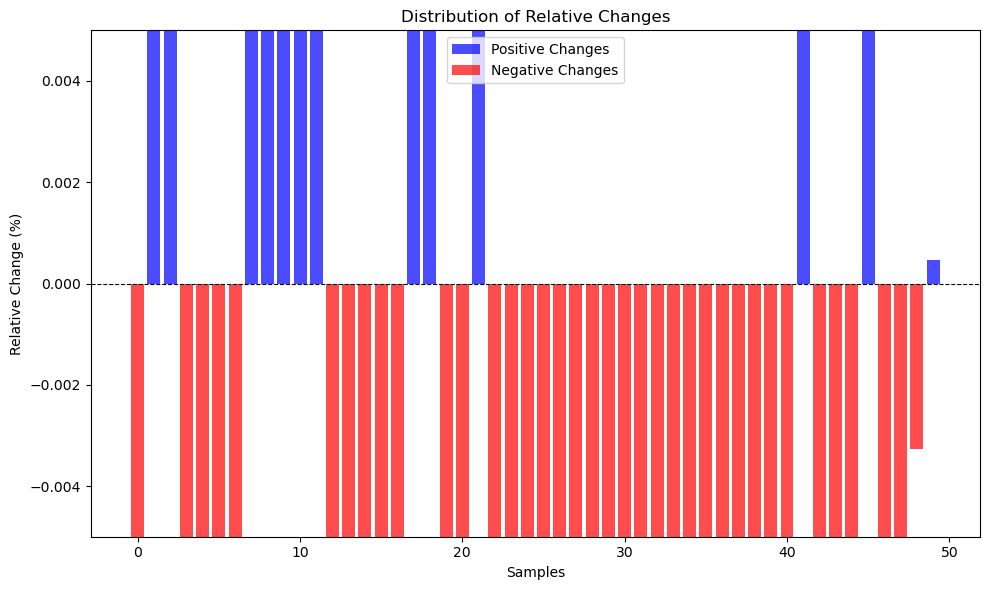

In [17]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_bert_results[0.5][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_bert_results[0.6][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_bert_results[0.7][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### Interpress

In [18]:
model_interpress_output = create_model_output_function(bert_model_interpress)
lig_interpress = LayerIntegratedGradients(model_interpress_output, bert_model_interpress.bert.embeddings)

interpress_bert_results = {}

for threshold in thresholds:

    ig_values_interpress, score_vis_interpress = apply_ig(path_ig, 
                                                          interpress_test, 
                                                          lig_interpress, 
                                                          bert_model_interpress, bert_tokenizer_interpress, 
                                                          f"ig_and_scores_interpress_{threshold}_bert",
                                                          device, 
                                                          only_load=only_load)
    
    top_tokens_interpress = apply_thresholding(ig_values_interpress, bert_tokenizer_interpress, threshold)
    
    ig_values_interpress_short, score_vis_interpress_short = apply_ig(path_ig, 
                                                                      top_tokens_interpress, 
                                                                      lig_interpress,
                                                                      bert_model_interpress, bert_tokenizer_interpress,
                                                                      f"ig_and_scores_interpress_short_{threshold}_bert", 
                                                                      device,
                                                                      only_load=only_load)
    
    interpress_bert_result = compare_probs(interpress_test,
                                           bert_full_text_preds_interpress,
                                           top_tokens_interpress,
                                           1,
                                           bert_model_interpress, bert_tokenizer_interpress,
                                           bert_pipeline_text_interpress,
                                           pipeline_parameters,
                                           device, 
                                           bert_id2label_interpress)

    interpress_bert_results[threshold] = (score_vis_interpress, score_vis_interpress_short, interpress_bert_result)
    
    clear_gpu_memory()
    
    show(interpress_bert_results[threshold][2], lengthMenu=list(range(10, 200, 30)), dom="lti")

'ig_and_scores_interpress_0.5_bert' file length: 50
'ig_and_scores_interpress_short_0.5_bert' file length: 50


'ig_and_scores_interpress_0.6_bert' file length: 50
'ig_and_scores_interpress_short_0.6_bert' file length: 50


'ig_and_scores_interpress_0.7_bert' file length: 50
'ig_and_scores_interpress_short_0.7_bert' file length: 50


In [19]:
sample_no = 21

viz.visualize_text([interpress_bert_results[0.6][0][sample_no]])
viz.visualize_text([interpress_bert_results[0.6][1][sample_no]])
display()


Explanations Contribution Score (ECS)          :  0.947
Overall Relative Change (ORC) positive changes :  9.7 %
Overall Relative Change (ORC) negative changes : -10.35 %


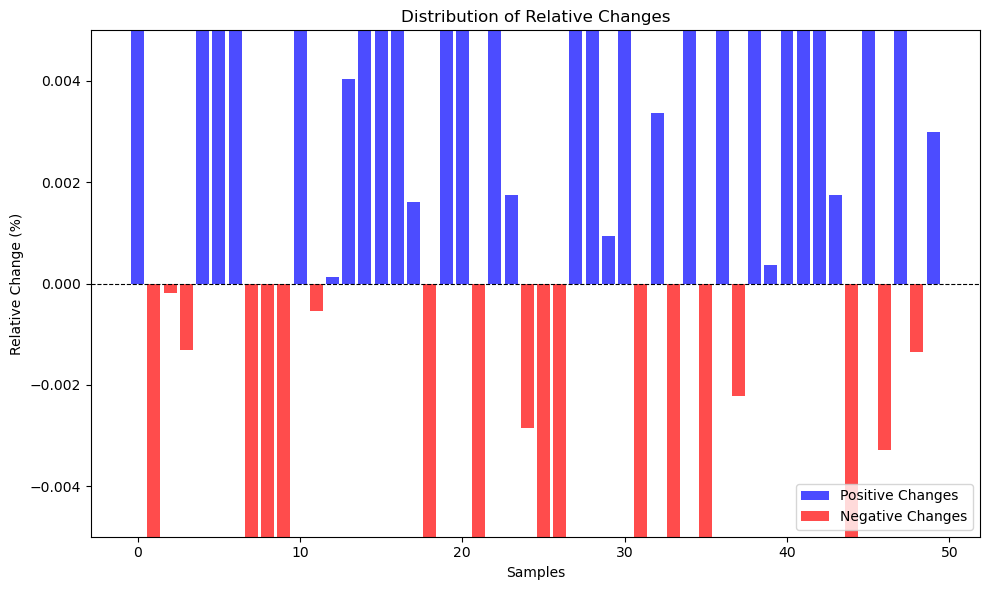


Explanations Contribution Score (ECS)          :  0.952
Overall Relative Change (ORC) positive changes :  9.41 %
Overall Relative Change (ORC) negative changes : -9.426 %


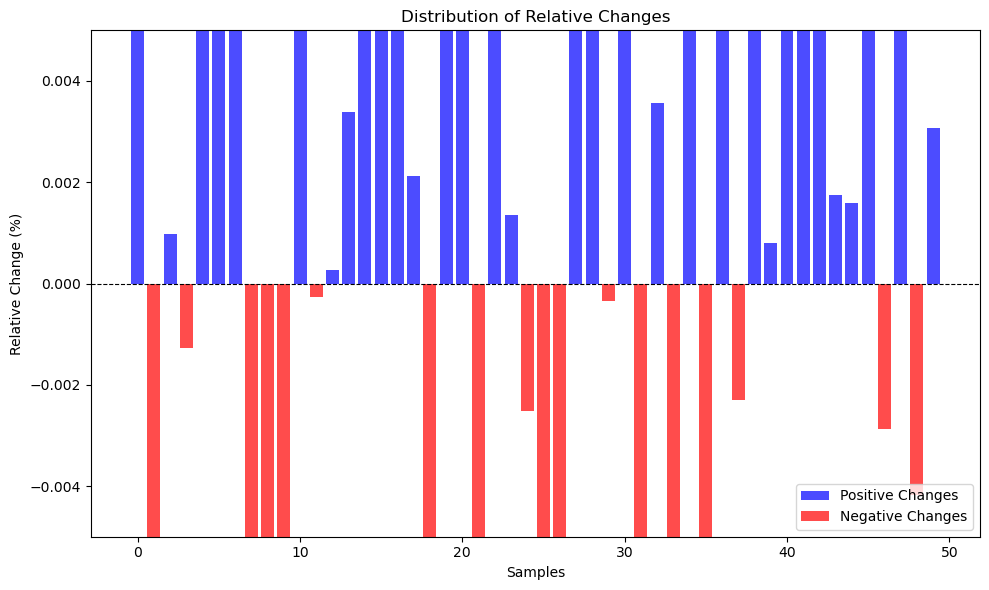


Explanations Contribution Score (ECS)          :  0.951
Overall Relative Change (ORC) positive changes :  10.403 %
Overall Relative Change (ORC) negative changes : -7.592 %


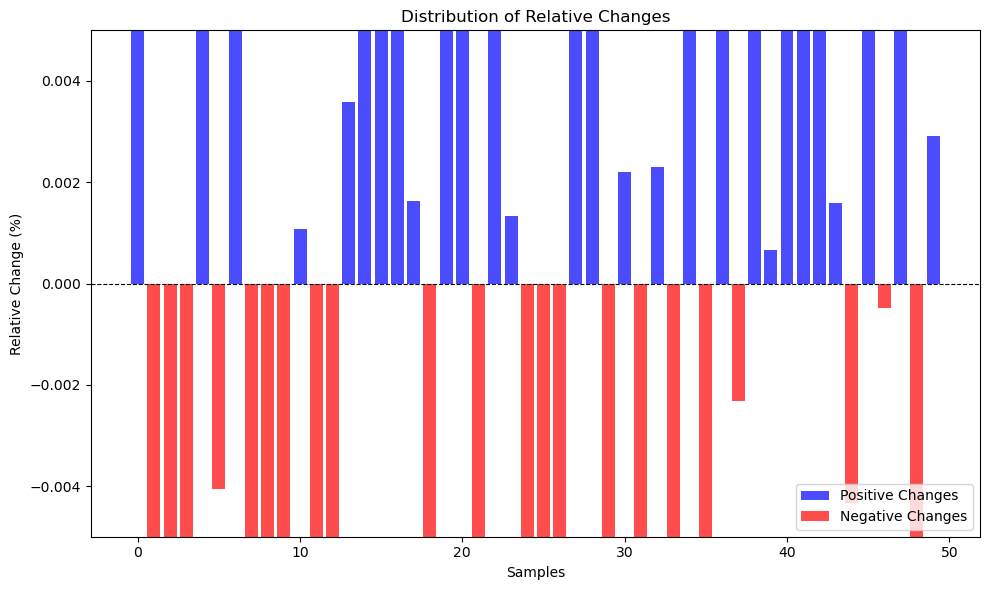

In [20]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_bert_results[0.5][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_bert_results[0.6][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_bert_results[0.7][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### TC 32

In [21]:
model_tc32_output = create_model_output_function(bert_model_tc32)
lig_tc32 = LayerIntegratedGradients(model_tc32_output, bert_model_tc32.bert.embeddings)

tc32_bert_results = {}

for threshold in thresholds:

    ig_values_tc32, score_vis_tc32 = apply_ig(path_ig, 
                                              tc32_test, 
                                              lig_tc32, 
                                              bert_model_tc32, bert_tokenizer_tc32, 
                                              f"ig_and_scores_tc32_{threshold}_bert",
                                              device,
                                              only_load=only_load)
    
    top_tokens_tc32 = apply_thresholding(ig_values_tc32, bert_tokenizer_tc32, threshold)
    
    ig_values_tc32_short, score_vis_tc32_short = apply_ig(path_ig, 
                                                          top_tokens_tc32, 
                                                          lig_tc32,
                                                          bert_model_tc32, bert_tokenizer_tc32,
                                                          f"ig_and_scores_tc32_short_{threshold}_bert", 
                                                          device,
                                                          only_load=only_load)
    
    tc32_bert_result = compare_probs(tc32_test,
                                     bert_full_text_preds_tc32,
                                     top_tokens_tc32,
                                     1,
                                     bert_model_tc32, bert_tokenizer_tc32,
                                     bert_pipeline_text_tc32,
                                     pipeline_parameters,
                                     device, 
                                     bert_id2label_tc32)

    tc32_bert_results[threshold] = (score_vis_tc32, score_vis_tc32_short, tc32_bert_result)
    
    clear_gpu_memory()
    
    show(tc32_bert_results[threshold][2], lengthMenu=list(range(10, 200, 30)), dom="lti")

'ig_and_scores_tc32_0.5_bert' file length: 50
'ig_and_scores_tc32_short_0.5_bert' file length: 50


'ig_and_scores_tc32_0.6_bert' file length: 50
'ig_and_scores_tc32_short_0.6_bert' file length: 50


'ig_and_scores_tc32_0.7_bert' file length: 50
'ig_and_scores_tc32_short_0.7_bert' file length: 50


In [22]:
sample_no = 41

viz.visualize_text([tc32_bert_results[0.6][0][sample_no]])
viz.visualize_text([tc32_bert_results[0.6][1][sample_no]])
display()


Explanations Contribution Score (ECS)          :  0.978
Overall Relative Change (ORC) positive changes :  1.053 %
Overall Relative Change (ORC) negative changes : -2.539 %


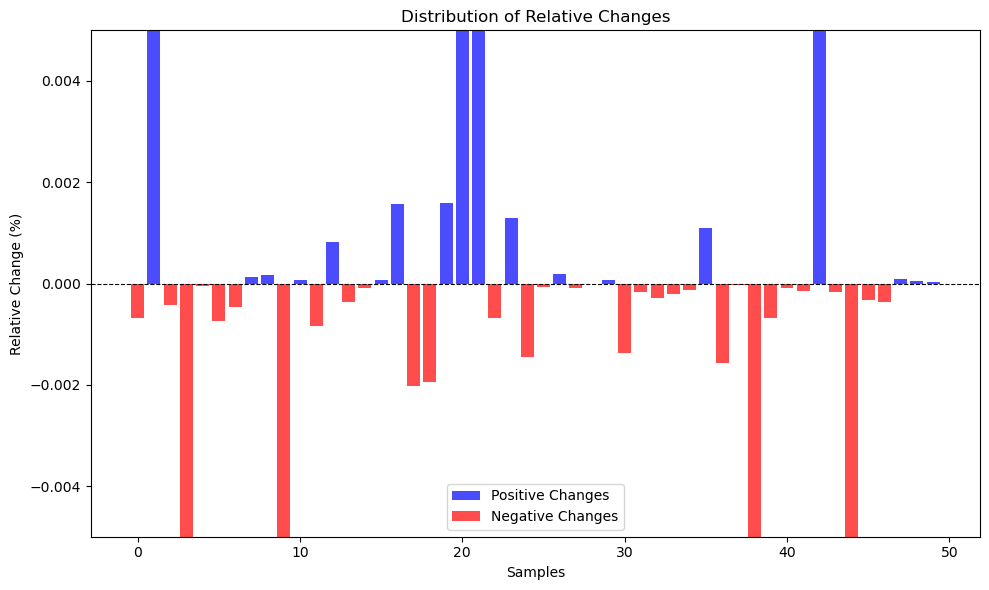


Explanations Contribution Score (ECS)          :  0.98
Overall Relative Change (ORC) positive changes :  0.238 %
Overall Relative Change (ORC) negative changes : -1.768 %


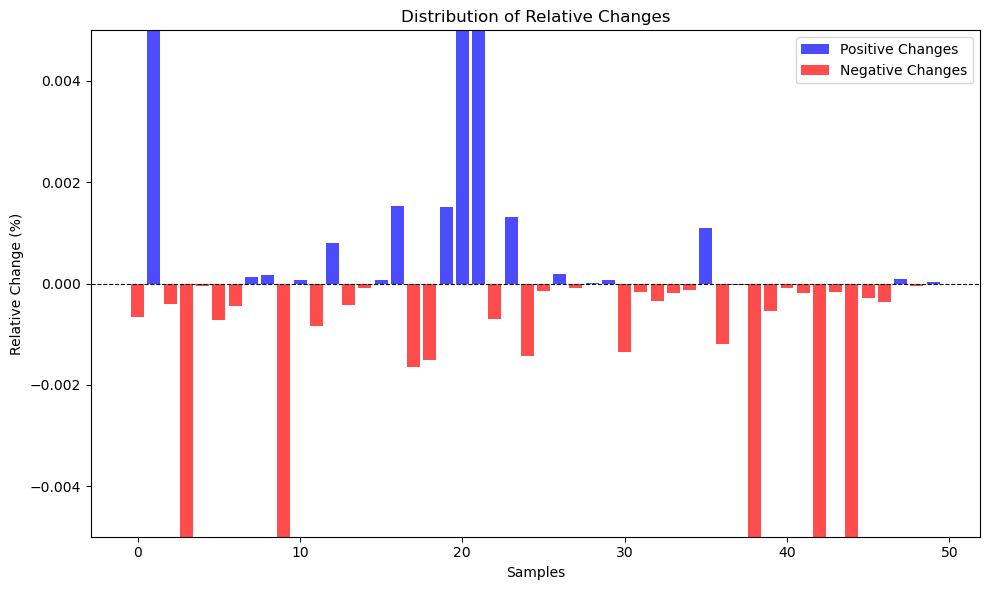


Explanations Contribution Score (ECS)          :  0.969
Overall Relative Change (ORC) positive changes :  0.588 %
Overall Relative Change (ORC) negative changes : -3.68 %


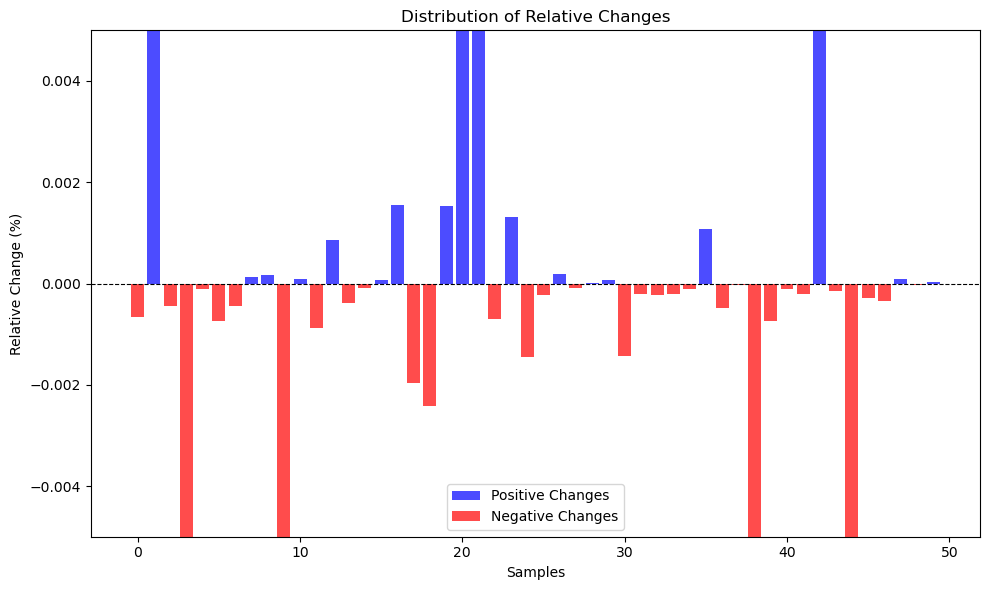

In [23]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_bert_results[0.5][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_bert_results[0.6][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_bert_results[0.7][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

### TurkishBERTweet

#### TTC4900

In [24]:
model_ttc4900_output = create_model_output_function(tbt_model_ttc4900)
lig_ttc4900 = LayerIntegratedGradients(model_ttc4900_output, tbt_model_ttc4900.roberta.embeddings)

ttc4900_tbt_results = {}

for threshold in thresholds:

    ig_values_ttc, score_vis_ttc = apply_ig(path_ig, 
                                            ttc4900_test, 
                                            lig_ttc4900, 
                                            tbt_model_ttc4900, tbt_tokenizer_ttc4900, 
                                            f"ig_and_scores_ttc_{threshold}_tbt", 
                                            device,
                                            only_load=only_load)
    
    top_tokens_ttc4900 = apply_thresholding(ig_values_ttc, tbt_tokenizer_ttc4900, threshold)
    
    ig_values_ttc_short, score_vis_ttc_short = apply_ig(path_ig, 
                                                        top_tokens_ttc4900, 
                                                        lig_ttc4900,
                                                        tbt_model_ttc4900, tbt_tokenizer_ttc4900, 
                                                        f"ig_and_scores_ttc_short_{threshold}_tbt",
                                                        device, 
                                                        only_load=only_load)
    
    ttc4900_tbt_result = compare_probs(ttc4900_test,
                                       tbt_full_text_preds_ttc4900,
                                       top_tokens_ttc4900,
                                       1,
                                       tbt_model_ttc4900, tbt_tokenizer_ttc4900,
                                       tbt_pipeline_text_ttc4900,
                                       pipeline_parameters,
                                       device, 
                                       tbt_id2label_ttc4900)

    ttc4900_tbt_results[threshold] = (score_vis_ttc, score_vis_ttc_short, ttc4900_tbt_result)
    
    clear_gpu_memory()
    
    show(ttc4900_tbt_results[threshold][2], lengthMenu=list(range(10, 200, 30)), dom="lti")

'ig_and_scores_ttc_0.5_tbt' file length: 50
'ig_and_scores_ttc_short_0.5_tbt' file length: 50


'ig_and_scores_ttc_0.6_tbt' file length: 50
'ig_and_scores_ttc_short_0.6_tbt' file length: 50


'ig_and_scores_ttc_0.7_tbt' file length: 50
'ig_and_scores_ttc_short_0.7_tbt' file length: 50


In [25]:
sample_no = 5

viz.visualize_text([ttc4900_tbt_results[0.6][0][sample_no]])
viz.visualize_text([ttc4900_tbt_results[0.6][1][sample_no]])
display()


Explanations Contribution Score (ECS)          :  0.988
Overall Relative Change (ORC) positive changes :  3.584 %
Overall Relative Change (ORC) negative changes : -2.66 %


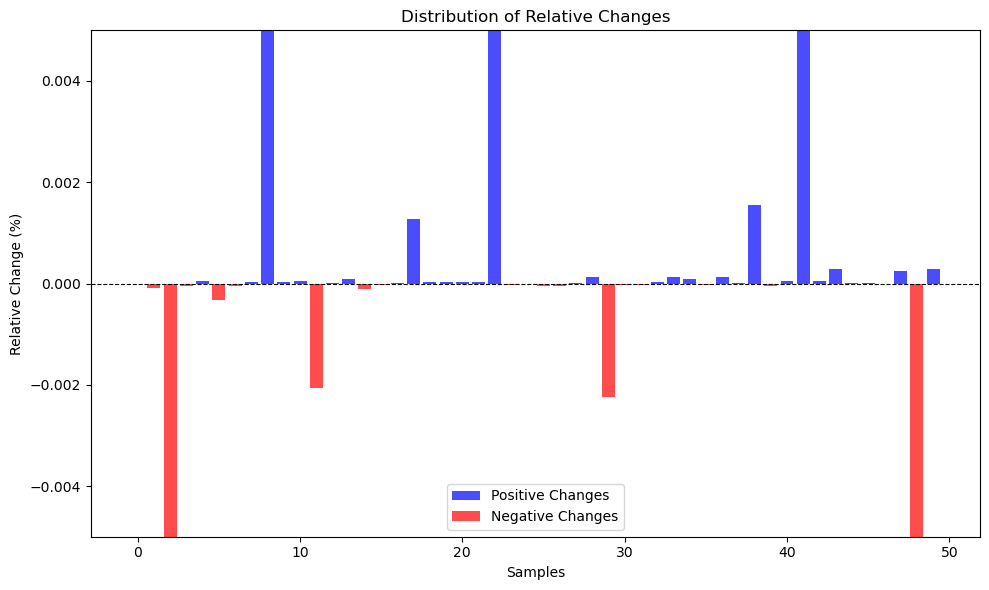


Explanations Contribution Score (ECS)          :  0.986
Overall Relative Change (ORC) positive changes :  3.956 %
Overall Relative Change (ORC) negative changes : -2.687 %


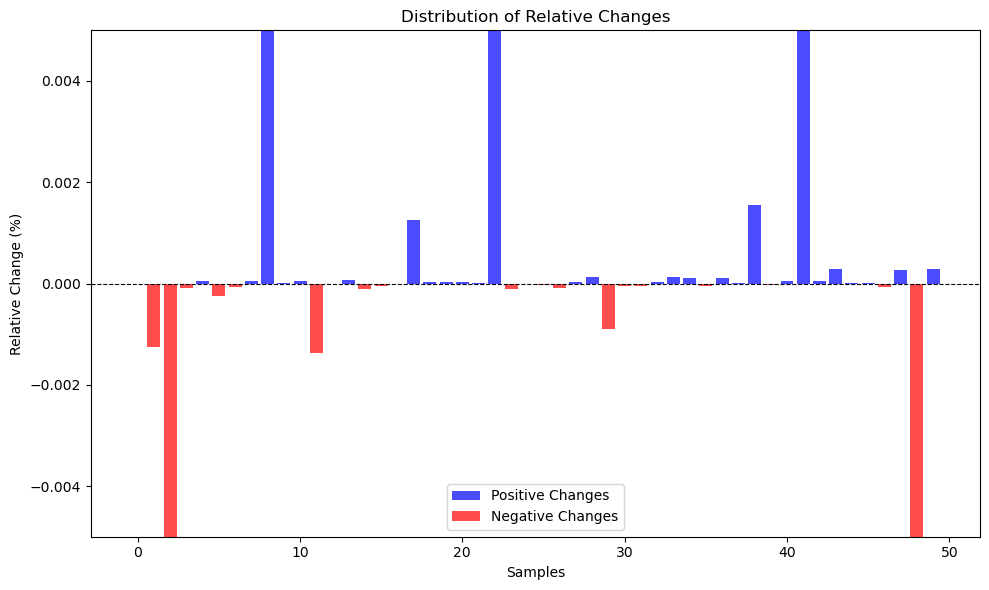


Explanations Contribution Score (ECS)          :  0.982
Overall Relative Change (ORC) positive changes :  3.638 %
Overall Relative Change (ORC) negative changes : -4.04 %


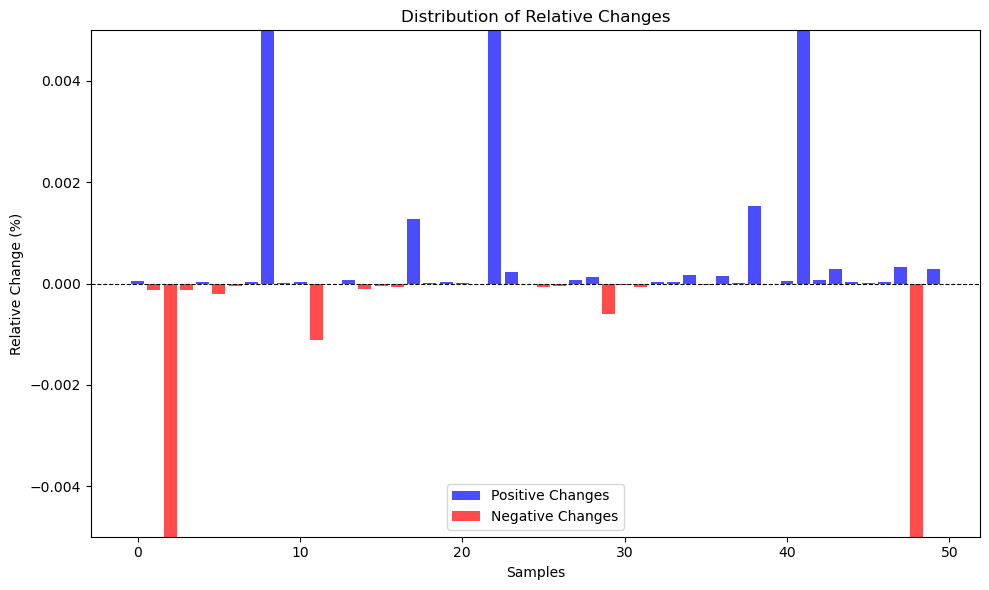

In [26]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_tbt_results[0.5][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_tbt_results[0.6][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_tbt_results[0.7][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### TR News

In [27]:
model_tr_news_output = create_model_output_function(tbt_model_tr_news)
lig_tr_news = LayerIntegratedGradients(model_tr_news_output, tbt_model_tr_news.roberta.embeddings)

tr_news_tbt_results = {}

for threshold in thresholds:

    ig_values_tr_news, score_vis_tr_news = apply_ig(path_ig, 
                                                    tr_news_test, 
                                                    lig_tr_news, 
                                                    tbt_model_tr_news, tbt_tokenizer_tr_news, 
                                                    f"ig_and_scores_tr_news_{threshold}_tbt",
                                                    device, 
                                                    only_load=only_load)
    
    top_tokens_tr_news = apply_thresholding(ig_values_tr_news, tbt_tokenizer_tr_news, threshold)
    
    ig_values_tr_news_short, score_vis_tr_news_short = apply_ig(path_ig, 
                                                                top_tokens_tr_news, 
                                                                lig_tr_news,
                                                                tbt_model_tr_news, tbt_tokenizer_tr_news,
                                                                f"ig_and_scores_tr_news_short_{threshold}_tbt",
                                                                device, 
                                                                only_load=only_load)
    
    tr_news_tbt_result = compare_probs(tr_news_test,
                                       tbt_full_text_preds_tr_news,
                                       top_tokens_tr_news,
                                       1,
                                       tbt_model_tr_news, tbt_tokenizer_tr_news,
                                       tbt_pipeline_text_tr_news,
                                       pipeline_parameters,
                                       device, 
                                       tbt_id2label_tr_news)

    tr_news_tbt_results[threshold] = (score_vis_tr_news, score_vis_tr_news_short, tr_news_tbt_result)
    
    clear_gpu_memory()
    
    show(tr_news_tbt_results[threshold][2], lengthMenu=list(range(10, 200, 30)), dom="lti")

'ig_and_scores_tr_news_0.5_tbt' file length: 50
'ig_and_scores_tr_news_short_0.5_tbt' file length: 50


'ig_and_scores_tr_news_0.6_tbt' file length: 50
'ig_and_scores_tr_news_short_0.6_tbt' file length: 50


'ig_and_scores_tr_news_0.7_tbt' file length: 50
'ig_and_scores_tr_news_short_0.7_tbt' file length: 50


In [28]:
sample_no = 2

viz.visualize_text([tr_news_tbt_results[0.6][0][sample_no]])
viz.visualize_text([tr_news_tbt_results[0.6][1][sample_no]])
display()


Explanations Contribution Score (ECS)          :  0.844
Overall Relative Change (ORC) positive changes :  9.621 %
Overall Relative Change (ORC) negative changes : -17.314 %


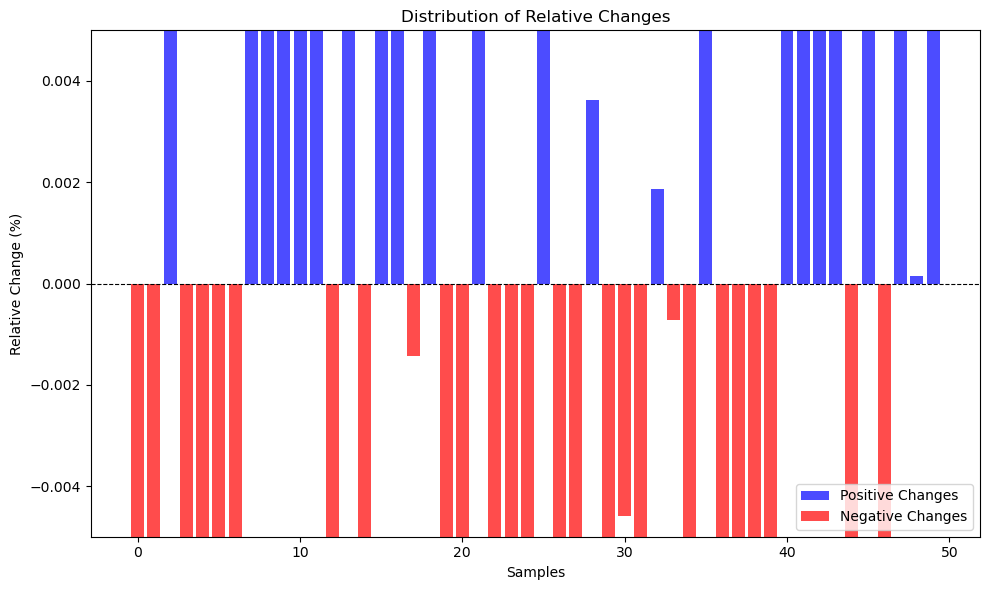


Explanations Contribution Score (ECS)          :  0.842
Overall Relative Change (ORC) positive changes :  10.257 %
Overall Relative Change (ORC) negative changes : -18.357 %


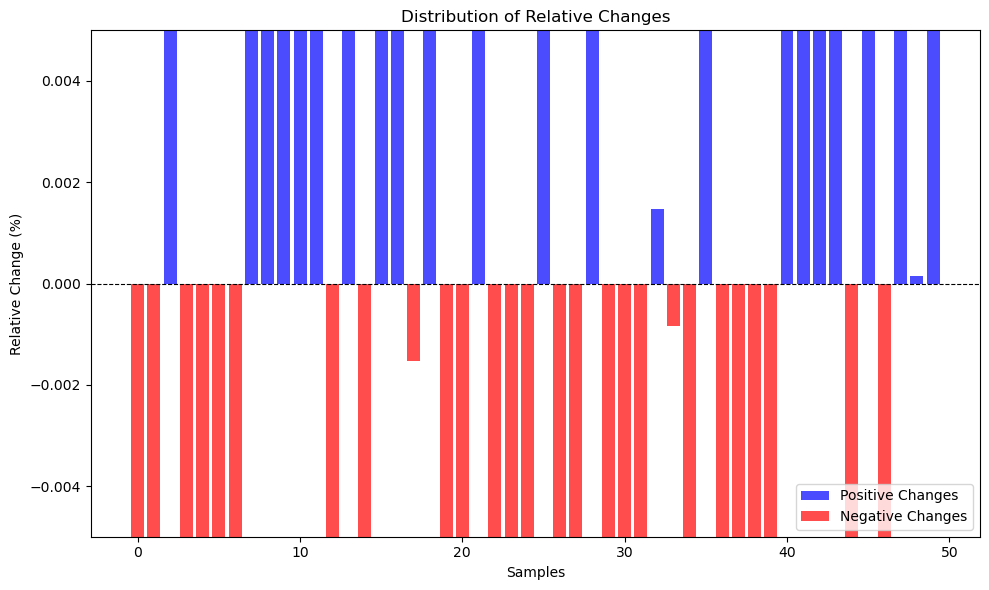


Explanations Contribution Score (ECS)          :  0.839
Overall Relative Change (ORC) positive changes :  10.157 %
Overall Relative Change (ORC) negative changes : -18.819 %


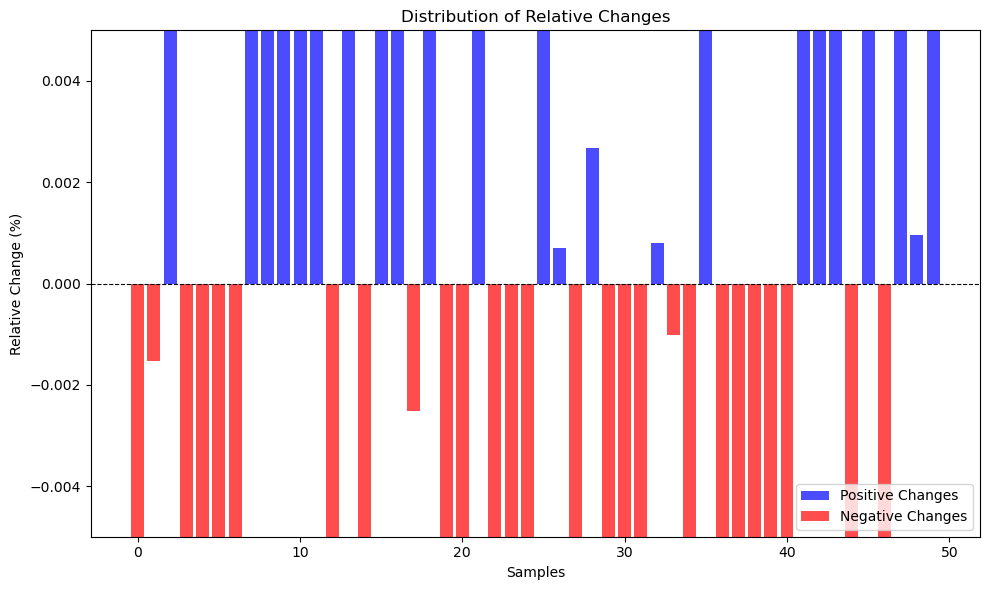

In [29]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_tbt_results[0.5][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_tbt_results[0.6][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_tbt_results[0.7][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### Interpress

In [30]:
model_interpress_output = create_model_output_function(tbt_model_interpress)
lig_interpress = LayerIntegratedGradients(model_interpress_output, tbt_model_interpress.roberta.embeddings)

interpress_tbt_results = {}

for threshold in thresholds:

    ig_values_interpress, score_vis_interpress = apply_ig(path_ig, 
                                                          interpress_test, 
                                                          lig_interpress, 
                                                          tbt_model_interpress, tbt_tokenizer_interpress, 
                                                          f"ig_and_scores_interpress_{threshold}_tbt",
                                                          device, 
                                                          only_load=only_load)
    
    top_tokens_interpress = apply_thresholding(ig_values_interpress, tbt_tokenizer_interpress, threshold)
    
    ig_values_interpress_short, score_vis_interpress_short = apply_ig(path_ig, 
                                                                      top_tokens_interpress, 
                                                                      lig_interpress,
                                                                      tbt_model_interpress, tbt_tokenizer_interpress,
                                                                      f"ig_and_scores_interpress_short_{threshold}_tbt",
                                                                      device, 
                                                                      only_load=only_load)
    
    interpress_tbt_result = compare_probs(interpress_test,
                                          tbt_full_text_preds_interpress,
                                          top_tokens_interpress,
                                          1,
                                          tbt_model_interpress, tbt_tokenizer_interpress,
                                          tbt_pipeline_text_interpress,
                                          pipeline_parameters,
                                          device, 
                                          tbt_id2label_interpress)

    interpress_tbt_results[threshold] = (score_vis_interpress, score_vis_interpress_short, interpress_tbt_result)
    
    clear_gpu_memory()
    
    show(interpress_tbt_results[threshold][2], lengthMenu=list(range(10, 200, 30)), dom="lti")

'ig_and_scores_interpress_0.5_tbt' file length: 50
'ig_and_scores_interpress_short_0.5_tbt' file length: 50


'ig_and_scores_interpress_0.6_tbt' file length: 50
'ig_and_scores_interpress_short_0.6_tbt' file length: 50


'ig_and_scores_interpress_0.7_tbt' file length: 50
'ig_and_scores_interpress_short_0.7_tbt' file length: 50


In [31]:
sample_no = 10

viz.visualize_text([interpress_tbt_results[0.6][0][sample_no]])
viz.visualize_text([interpress_tbt_results[0.6][1][sample_no]])
display()


Explanations Contribution Score (ECS)          :  0.889
Overall Relative Change (ORC) positive changes :  22.871 %
Overall Relative Change (ORC) negative changes : -17.473 %


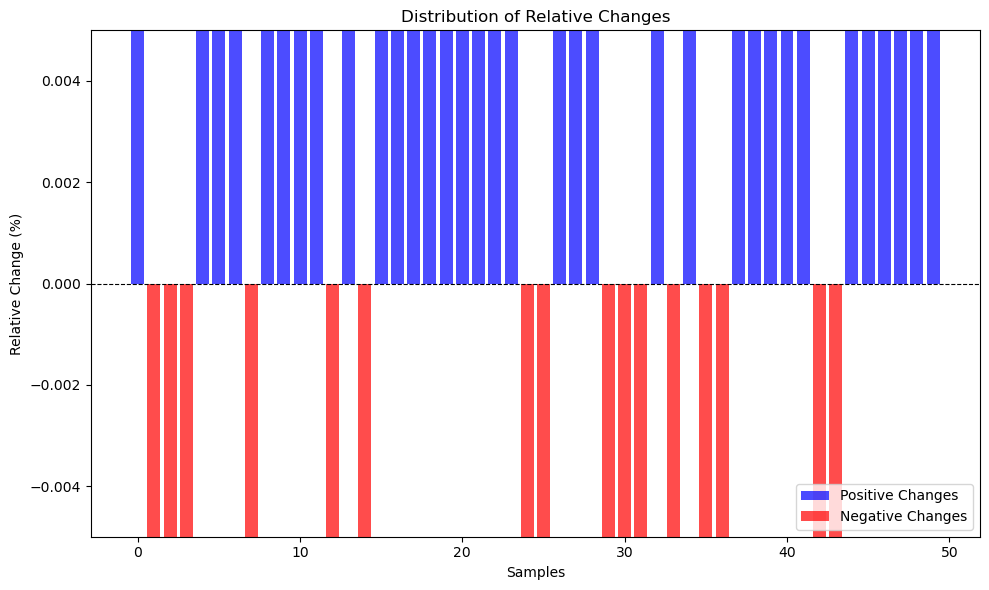


Explanations Contribution Score (ECS)          :  0.92
Overall Relative Change (ORC) positive changes :  22.445 %
Overall Relative Change (ORC) negative changes : -13.897 %


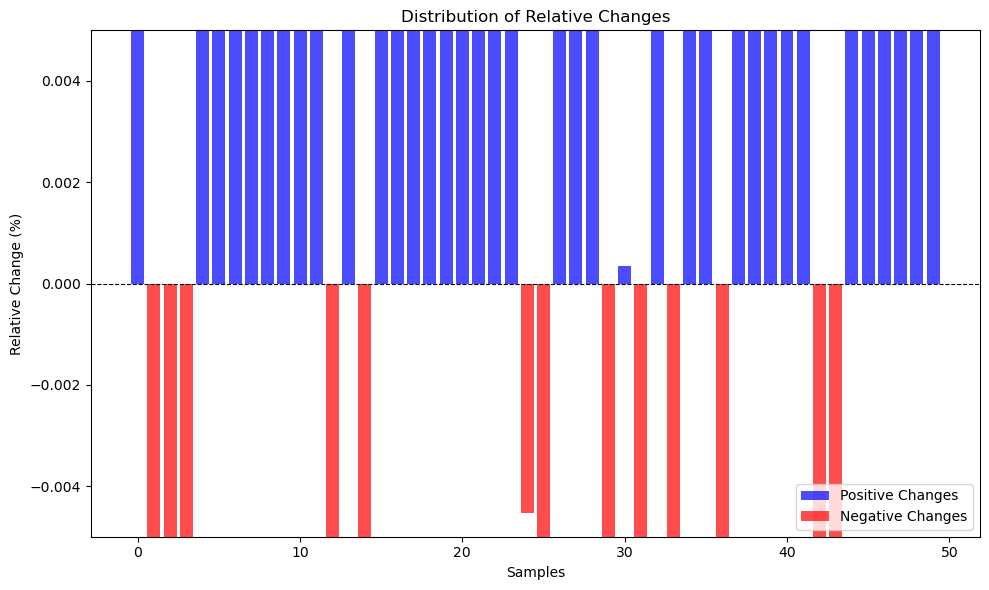


Explanations Contribution Score (ECS)          :  0.922
Overall Relative Change (ORC) positive changes :  21.9 %
Overall Relative Change (ORC) negative changes : -17.264 %


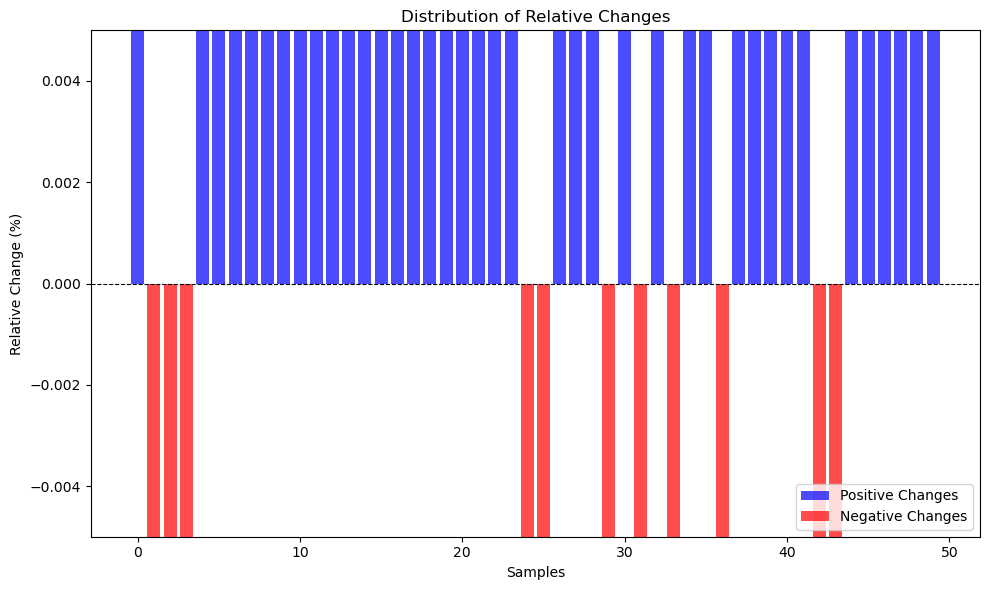

In [32]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_tbt_results[0.5][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_tbt_results[0.6][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_tbt_results[0.7][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### TC32

In [33]:
model_tc32_output = create_model_output_function(tbt_model_tc32)
lig_tc32 = LayerIntegratedGradients(model_tc32_output, tbt_model_tc32.roberta.embeddings)

tc32_tbt_results = {}

for threshold in thresholds:

    ig_values_tc32, score_vis_tc32 = apply_ig(path_ig, 
                                              tc32_test, 
                                              lig_tc32, 
                                              tbt_model_tc32, tbt_tokenizer_tc32, 
                                              f"ig_and_scores_tc32_{threshold}_tbt",
                                              device, 
                                              only_load=only_load)
    
    top_tokens_tc32 = apply_thresholding(ig_values_tc32, tbt_tokenizer_tc32, threshold)
    
    ig_values_tc32_short, score_vis_tc32_short = apply_ig(path_ig, 
                                                          top_tokens_tc32, 
                                                          lig_tc32,
                                                          tbt_model_tc32, tbt_tokenizer_tc32,
                                                          f"ig_and_scores_tc32_short_{threshold}_tbt",
                                                          device, 
                                                          only_load=only_load)
    
    tc32_tbt_result = compare_probs(tc32_test,
                                    tbt_full_text_preds_tc32,
                                    top_tokens_tc32,
                                    1,
                                    tbt_model_tc32, tbt_tokenizer_tc32,
                                    tbt_pipeline_text_tc32,
                                    pipeline_parameters,
                                    device, 
                                    tbt_id2label_tc32)

    tc32_tbt_results[threshold] = (score_vis_tc32, score_vis_tc32_short, tc32_tbt_result)
    
    clear_gpu_memory()
    
    show(tc32_tbt_results[threshold][2], lengthMenu=list(range(10, 200, 30)), dom="lti")

'ig_and_scores_tc32_0.5_tbt' file length: 50
'ig_and_scores_tc32_short_0.5_tbt' file length: 50


'ig_and_scores_tc32_0.6_tbt' file length: 50
'ig_and_scores_tc32_short_0.6_tbt' file length: 50


'ig_and_scores_tc32_0.7_tbt' file length: 50
'ig_and_scores_tc32_short_0.7_tbt' file length: 50


In [34]:
sample_no = 19

viz.visualize_text([tc32_tbt_results[0.6][0][sample_no]])
viz.visualize_text([tc32_tbt_results[0.6][1][sample_no]])
display()


Explanations Contribution Score (ECS)          :  0.961
Overall Relative Change (ORC) positive changes :  11.443 %
Overall Relative Change (ORC) negative changes : -5.12 %


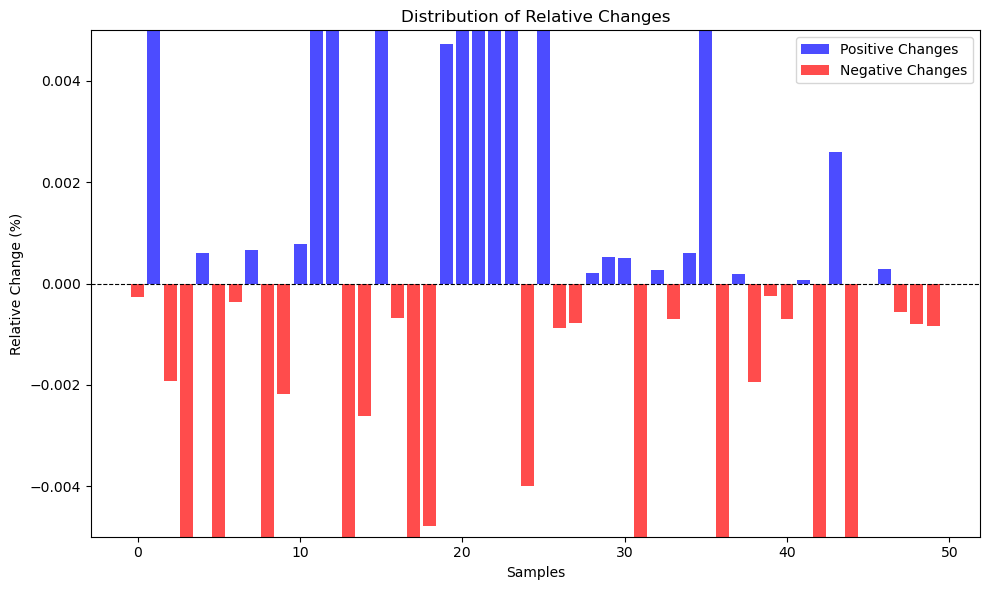


Explanations Contribution Score (ECS)          :  0.968
Overall Relative Change (ORC) positive changes :  11.035 %
Overall Relative Change (ORC) negative changes : -4.124 %


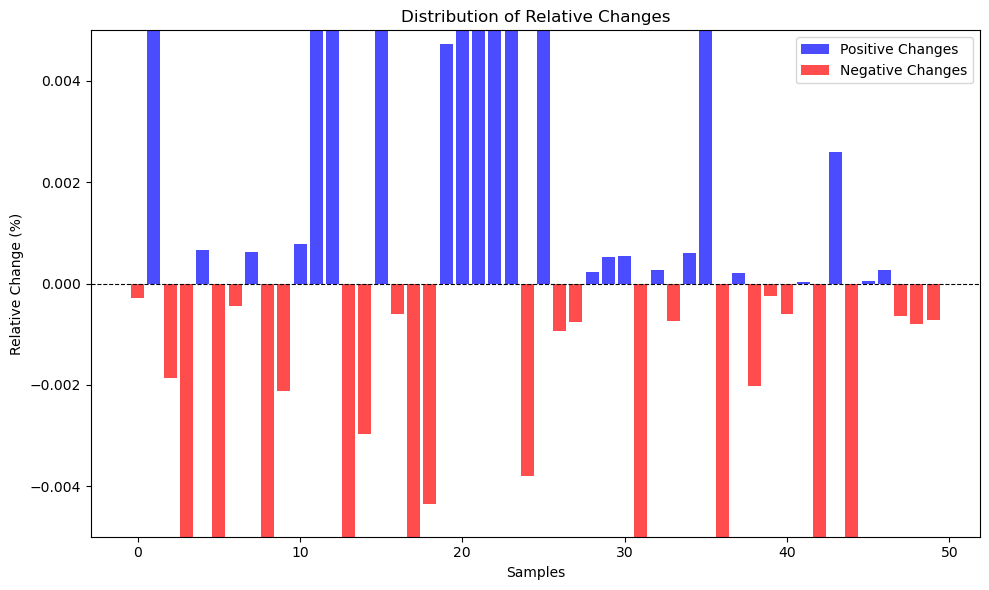


Explanations Contribution Score (ECS)          :  0.965
Overall Relative Change (ORC) positive changes :  10.946 %
Overall Relative Change (ORC) negative changes : -4.045 %


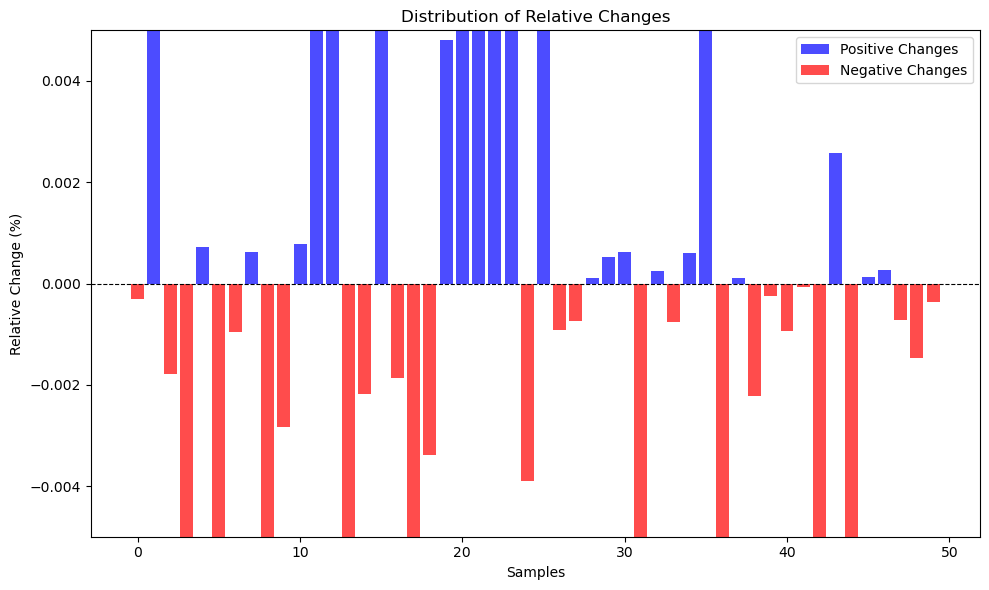

In [35]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_tbt_results[0.5][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_tbt_results[0.6][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_tbt_results[0.7][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)